# Build the LSLGA parent sample

The purpose of this notebook is to build the parent sample for the NASA Legacy Surveys Galaxy Atlas (NLSGA).

Our starting catalog is the file *ned-d25min10.txt*, which contains 8,131,378 objects and is the (semi-raw) output of querying the NED database (on 2018 March 26) for all objects with a D(25) isophotal diameter (in any band) greater than 10 arcsec, with no requirements on redshift or object type.  

Next, we run
```bash
% time python parse-ned-sample
```
to restrict the sample to just "galaxies" (object type "G", "GGroup", "GPair", "GTrpl", or "PofG"), which leaves 4,755,411 objects, and to write out a more conveniently formatted FITS file, *ned-d25min10.fits*.  

Specifically, we parse and merge various apparent magnitude estimates (from SDSS/r, 2MASS/Ks, RC3/B, and APM/bJ, in that order of priority), and angular diameters (D25), minor-to-major axis ratios (b/a), and position angles (pa) (from SDSS, 2MASS, RC3, and ESO, in that order of priority).

### Imports and paths

In [1]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
sns.set(style='ticks', font_scale=1.5, palette='Set2')
%matplotlib inline

In [5]:
dr = 'dr5'
NLSGAdir = os.getenv('LSLGA_DIR')
nedtxtfile = os.path.join(NLSGAdir, 'sample', 'ned-d25min10.txt')
nedfitsfile = os.path.join(NLSGAdir, 'sample', 'ned-d25min10.fits')

In [6]:
def get_d25(data):
    """Consolidate the angular diameter estimates.  Priority ranking: SDSS, 2MASS, RC3, ESO.
    """
    nobj = len(data)
    d25 = np.empty(nobj) * np.nan
    band = np.chararray(nobj).astype('<U5')
    for source, filt in zip( ('sdss_d25', 'twomass_d25', 'rc3_d25', 'eso_d25'),
                             ('r', 'Ks', 'B_RC3', 'B_ESO') ):
        indx = data[source].notnull() & np.isnan(d25)
        if np.count_nonzero(indx) > 0:
            #if 'ESO' in source:
            #    print(data[source][indx].astype('f4'))
            #    import pdb ; pdb.set_trace()
            d25[indx] = data[source][indx].astype('f4') # [arcsec]
            band[indx] = filt
    return d25, band

In [7]:
def get_mag(data):
    """rough magnitude.  Priority ranking: APM, RC3, 2MASS, RC3.
    """
    nobj = len(data)
    mag = np.empty(nobj) * np.nan
    band = np.chararray(nobj).astype('<U5')
    for source, filt in zip( ('sdss_r', 'twomass_K', 'rc3_B', 'apm_b'),
                             ('r', 'Ks', 'B_RC3', 'bJ') ):
        indx = data[source].notnull() & data[source] > 0 & np.isnan(mag)
        if np.count_nonzero(indx) > 0:
            mag[indx] = -2.5 * np.log10( data[source][indx].astype('f4') * 1e3 ) - 48.6
            band[indx] = filt
    return mag, band

In [8]:
def read_ned(zcut=False, nrows=None):
    names = ('note', 'name', 'ra_hms', 'dec_hms', 'object', 'z', 'zqual', 
             'morph', 'sdss_r', 'sdss_r_err', 'rc3_B', 'rc3_B_err', 
             'apm_b', 'apm_b_err', 'twomass_K', 'twomass_K_err', 
             'sdss_d25', 'sdss_ba25', 'sdss_pa', 'twomass_d25', 
             'twomass_ba25', 'twomass_pa', 'rc3_d25', 'rc3_ba25', 
             'rc3_pa', 'eso_d25', 'eso_ba25', 'eso_pa')
    
    data = pd.read_csv(nedtxtfile, delimiter='|', skiprows=5, names=names, nrows=nrows)
    data = data.loc[data['object'].str.contains(r'G')]
    data = data.replace(r'^\s*$', np.nan, regex=True)
    
    if zcut:
        data = data.loc[data['z'].notnull()]
    
    coord = SkyCoord(ra=data['ra_hms'], dec=data['dec_hms'], unit=(u.hourangle, u.deg))
    
    out = pd.DataFrame()
    out['name'] = data['name']
    out['ra'] = coord.ra.value
    out['dec'] = coord.dec.value
    out['z'] = data['z'].astype('f4')
    out['zqual'] = data['zqual']
    out['morph'] = data['morph']
    
    # get magnitudes
    mag, band = get_mag(data)
    out['mag'] = mag
    out['mag_band'] = band

    # get D(25)
    d25, band = get_d25(data)
    out['d25'] = d25
    out['d25_band'] = band
    
    return data, out

In [9]:
%time data, out = read_ned(nrows=1000, zcut=True)

CPU times: user 120 ms, sys: 23.4 ms, total: 143 ms
Wall time: 170 ms


In [10]:
out

,name,ra,dec,z,zqual,morph,mag,mag_band,d25,d25_band
7,SDSS J113215.64+344212.9,173.065208,34.703611,0.272720,NaN,NaN,17.626991,r,19.209999,r
11,SDSS J114500.79+150010.4,176.253292,15.002917,0.336505,NaN,NaN,18.519279,r,10.400000,r
13,2MASX J11564998+2701421,179.208250,27.028333,0.159669,NaN,NaN,17.539833,r,14.760000,r
14,SDSS J095550.81+004114.1,148.961708,0.687278,0.095322,NaN,NaN,17.037315,r,21.870001,r
16,SDSS J123329.43+142730.3,188.372667,14.458444,0.328000,PHOT,NaN,17.958557,r,13.470000,r
26,MCG -03-30-018,178.581917,-18.950111,0.023570,NaN,NaN,12.620293,Ks,38.000000,Ks
27,IC 5262,343.835208,-33.887917,0.028767,NaN,NaN,11.985828,Ks,49.799999,Ks
31,SDSS J160415.26+422221.2,241.063625,42.372583,0.210266,SPEC,NaN,17.922661,r,12.100000,r
37,SDSS J125541.45+500328.8,193.922708,50.058028,0.304758,SPEC,NaN,18.489120,r,11.630000,r
46,SDSS J154610.52+104333.9,236.543875,10.726111,0.118552,NaN,NaN,17.408508,r,15.110000,r


In [11]:
print('Writing {}'.format(nedfitsfile))
Table.from_pandas(out).write(nedfitsfile, overwrite=True)

Writing /Users/ioannis/research/projects/LSLGA/sample/ned-d25min10.fits


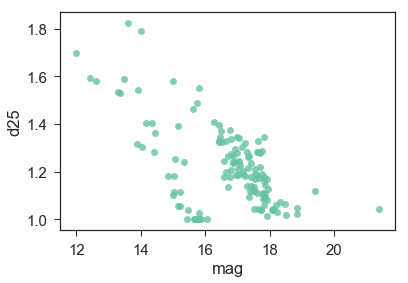

In [25]:
sns.regplot(x=out['mag'], y=np.log10(out['d25']), fit_reg=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20163cc0>]], dtype=object)

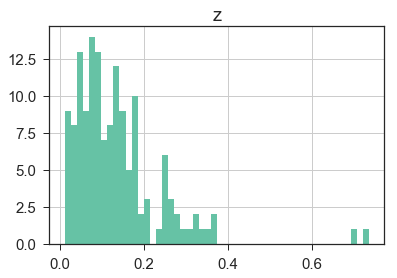

In [27]:
out.hist(column='z', bins=50)

In [28]:
out['z'].describe()

count    144.000000
mean       0.133731
std        0.107889
min        0.011290
25%        0.064311
50%        0.105830
75%        0.172098
max        0.734850
Name: z, dtype: float64

In [15]:
stop

NameError: name 'stop' is not defined

In [ ]:
data.loc[15]

In [ ]:
data['sdss_d25'], data['twomass_d25']

### Read the parent HyperLeda catalog

In [ ]:
def _catalog_template(nobj=1):
    cols = [
        ('GALAXY', 'S28'), 
        ('PGC', 'S10'), 
        ('RA', 'f8'), 
        ('DEC', 'f8'),
        ('TYPE', 'S8'),
        ('MULTIPLE', 'S1'),
        ('RADIUS', 'f4'),
        ('BA', 'f4'),
        ('PA', 'f4'),
        ('BMAG', 'f4'),
        ('IMAG', 'f4'),
        ('VHELIO', 'f4'),
        ('BRICKNAME', 'S17', (4,))
        ]
    catalog = Table(np.zeros(nobj, dtype=cols))
    catalog['RADIUS'].unit = 'arcsec'
    catalog['VHELIO'].unit = 'km/s'

    return catalog

In [ ]:
def read_leda(largedir='.', d25min=0.0, d25max=1000.0, decmin=-90.0, 
              decmax=+90.0, ramin=0.0, ramax=360.0):
    """Read the parent LEDA catalog and put it in a standard format.
    
    """
    cat = fits.getdata(os.path.join(largedir, 'sample', 'leda-logd25-0.05.fits.gz'), 1)

    outcat = _catalog_template(len(cat))
    outcat['GALAXY'] = cat['GALAXY']
    outcat['PGC'] = cat['PGC']
    outcat['RA'] = cat['RA']
    outcat['DEC'] = cat['DEC']
    outcat['TYPE'] = cat['TYPE']
    outcat['MULTIPLE'] = cat['MULTIPLE']
    outcat['RADIUS'] = cat['D25']/2.0 # semi-major axis radius [arcsec]
    outcat['BA'] = cat['BA']
    outcat['PA'] = cat['PA']
    outcat['BMAG'] = cat['BMAG']
    outcat['IMAG'] = cat['IMAG']
    outcat['VHELIO'] = cat['VHELIO']

    these = np.where((outcat['RADIUS']*2/60.0 <= d25max) *
                     (outcat['RADIUS']*2/60.0 >= d25min) *
                     (outcat['DEC'] <= decmax) *
                     (outcat['DEC'] >= decmin) *
                     (outcat['RA'] <= ramax) *
                     (outcat['RA'] >= ramin)
                     )[0]
    outcat = outcat[these] 

    return outcat

In [ ]:
survey = LegacySurveyData()

In [ ]:
bricks = survey.get_bricks()
allccds = survey.get_annotated_ccds()
cut = survey.photometric_ccds(allccds)
if cut is not None:
    allccds.cut(cut)
cut = survey.ccd_cuts(allccds)
allccds.cut(cut == 0)
print('Read {} CCDs.'.format(len(allccds)))

In [ ]:
        # Read the parent super-sample.
        if False:
            print('Testing with smaller sample cuts!')
            d25min, d25max = 1.0, 5.0
            ramin, ramax = 175, 185
        else:
            d25min, d25max = 0.5, 10.0
            ramin, ramax = 0, 360

        cat = read_leda(largedir=largedir, d25min=d25min, d25max=d25max,
                        decmax=np.max(allccds.dec)+0.3,
                        decmin=np.min(allccds.dec)-0.3,


### Build the parent sample

In [ ]:
def _build_sample_onegalaxy(args):
    """Filler function for the multiprocessing."""
    return build_sample_onegalaxy(*args)

In [ ]:
def build_sample_onegalaxy(gal, allccds, ccdsdir, bricks, survey):
    """Wrapper function to find overlapping CCDs for a given galaxy.

    First generously find the nearest set of CCDs that are near the galaxy and
    then demand that there's 3-band coverage in a much smaller region centered
    on the galaxy.

    """
    #print('Working on {}...'.format(gal['GALAXY'].strip()))
    galwcs = _galwcs(gal)
    these = ccds_touching_wcs(galwcs, allccds)

    if len(these) > 0:
        ccds1 = _uniqccds( allccds[these] )

        # Is there 3-band coverage?
        galwcs_small = _galwcs(gal, factor=0.5)
        these_small = ccds_touching_wcs(galwcs_small, ccds1)
        ccds1_small = _uniqccds( ccds1[these_small] )

        if 'g' in ccds1_small.filter and 'r' in ccds1_small.filter and 'z' in ccds1_small.filter:
            print('For {} found {} CCDs, RA = {:.5f}, Dec = {:.5f}, Radius={:.4f} arcsec'.format(
                gal['GALAXY'].strip(), len(ccds1), gal['RA'], gal['DEC'], gal['RADIUS']))

            ccdsfile = os.path.join(ccdsdir, '{}-ccds.fits'.format(gal['GALAXY'].strip().lower()))
            #print('  Writing {}'.format(ccdsfile))
            if os.path.isfile(ccdsfile):
                os.remove(ccdsfile)
            ccds1.writeto(ccdsfile)

            # Also get the set of bricks touching this footprint.
            rad = 2*gal['RADIUS']/3600 # [degree]
            brickindx = survey.bricks_touching_radec_box(bricks,
                                                         gal['RA']-rad, gal['RA']+rad,
                                                         gal['DEC']-rad, gal['DEC']+rad)
            if len(brickindx) == 0 or len(brickindx) > 4:
                print('This should not happen!')
                pdb.set_trace()
            gal['BRICKNAME'][:len(brickindx)] = bricks.brickname[brickindx]

            return [gal, ccds1]

    return None


In [ ]:
samplefile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-{}.fits'.format(dr))
sample = fits.getdata(samplefile, 1)